In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils.conn_data import load_pickle
from portfolio_tools.Diagnostics import Diagnostics
from functionals.Functionals import Functionals

plt.style.use('ggplot')

In [3]:
# parameters
train = True
strategy_name = "etfstsm"
diag = Diagnostics()

strategy_name = f"training_{strategy_name}" if train else strategy_name

# paths
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
dirs = sorted(os.listdir(os.path.join(outputs_path, strategy_name)))

print(dirs)

['% Positive Ret._means_0.25_100', '% Positive Ret._means_0.5_100', '% Positive Ret._means_0.75_100', '% Positive Ret._means_0.95_100', '% Positive Ret._means_1.0_100', 'AvgDD_means_0.25_100', 'AvgDD_means_0.5_100', 'AvgDD_means_0.75_100', 'AvgDD_means_0.95_100', 'AvgDD_means_1.0_100', 'MaxDD_means_0.25_100', 'MaxDD_means_0.5_100', 'MaxDD_means_0.75_100', 'MaxDD_means_0.95_100', 'MaxDD_means_1.0_100', 'Sharpe_means_0.25_100', 'Sharpe_means_0.5_100', 'Sharpe_means_0.75_100', 'Sharpe_means_0.95_100', 'Sharpe_means_1.0_100', 'Sharpe_means_1_0']


In [8]:
dir = "Sharpe_means_0.95_100"
utility = dir.split("_")[0]
functional = dir.split("_")[1]
alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
Bsize = dir.split("_")[3]

functionals = Functionals(alpha=float(alpha))

optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

In [9]:
optmization_train.keys()

dict_keys(['hyperparameters', 'utilities', 'final_utility', 'robust_parameter'])

In [12]:
optmization_train["final_utility"]

tensor([ 1.5520e-01, -3.2096e-01,  1.8208e-01,  3.5485e-01,  1.1812e-01,
         8.0347e-01,  2.4752e-03,  4.7865e-01, -1.0028e-01,  8.2097e-01,
        -7.4201e-03, -1.7581e-02, -7.6428e-02, -4.9814e-04,  1.4321e-01,
         3.6477e-01,  1.6370e-02,  3.8108e-01,  3.1827e-01,  3.9843e-01,
        -9.8284e-02,  3.8205e-01, -4.1155e-02, -4.4927e-01, -7.2187e-02,
        -9.5568e-02, -2.1313e-01,  4.2506e-01,  6.4745e-01, -3.6727e-01,
         4.3826e-02,  1.0787e-01,  4.8311e-01, -1.0039e-01, -2.2955e-01,
        -2.5901e-01,  1.2520e-01, -2.0415e-01,  4.2679e-01,  9.5139e-02,
         1.4224e-01,  1.6691e-01, -3.2194e-01,  4.3674e-01,  1.4652e-01,
         1.1343e+00,  5.1138e-01, -1.5971e-01, -2.9409e-01, -8.2408e-02,
        -2.2772e-03,  2.0989e-02,  7.2424e-01,  3.2315e-01,  4.1709e-01,
        -1.4278e-01,  7.8504e-01,  3.5671e-01,  1.6121e-01,  3.0434e-01,
         1.0464e-01, -2.0625e-01,  3.5000e-01, -2.2504e-01,  1.2614e-02,
         1.1815e-01,  3.6286e-01,  7.2672e-01,  3.9

Utility: % Positive Ret., Functional: means, Alpha: 0.25, Bsize: 100


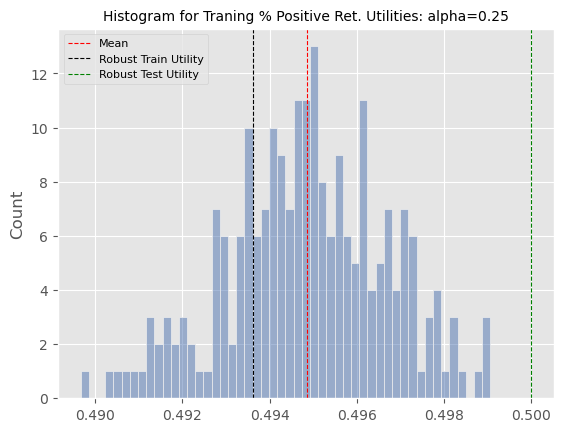

Utility: % Positive Ret., Functional: means, Alpha: 0.5, Bsize: 100


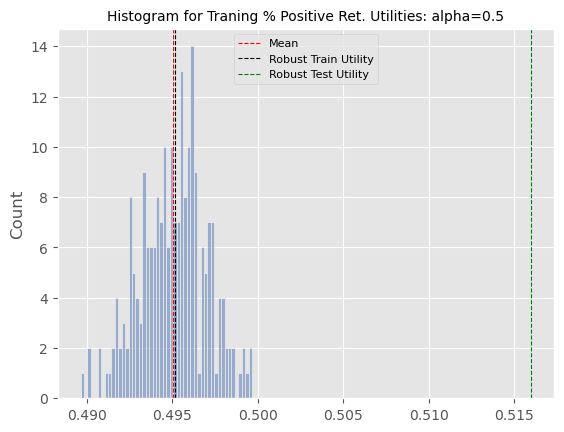

Utility: % Positive Ret., Functional: means, Alpha: 0.75, Bsize: 100


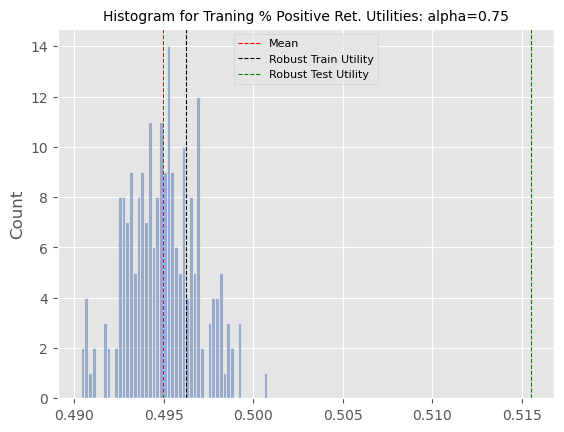

Utility: % Positive Ret., Functional: means, Alpha: 0.95, Bsize: 100


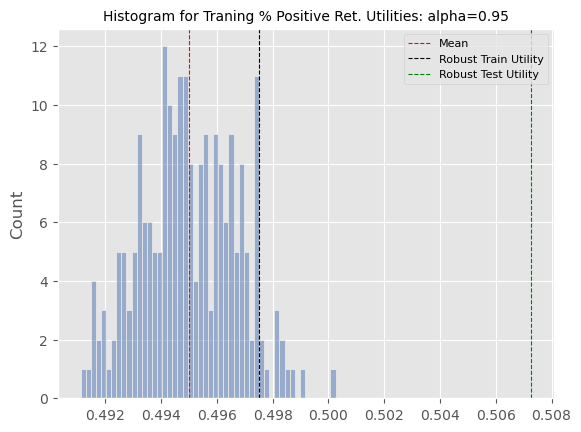

Utility: % Positive Ret., Functional: means, Alpha: 1.0, Bsize: 100


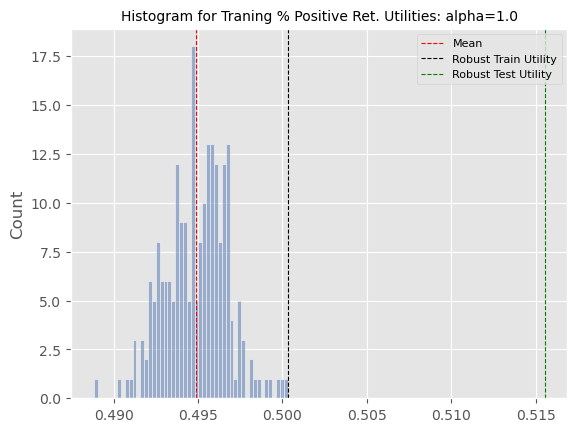

Utility: AvgDD, Functional: means, Alpha: 0.25, Bsize: 100


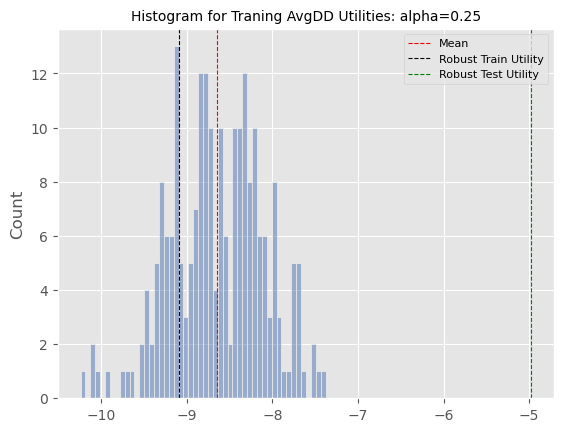

Utility: AvgDD, Functional: means, Alpha: 0.5, Bsize: 100


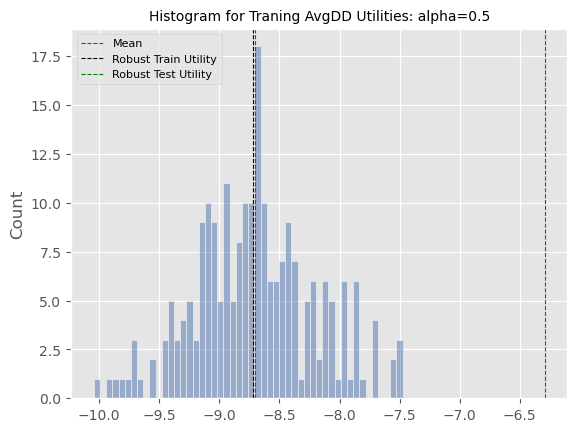

Utility: AvgDD, Functional: means, Alpha: 0.75, Bsize: 100


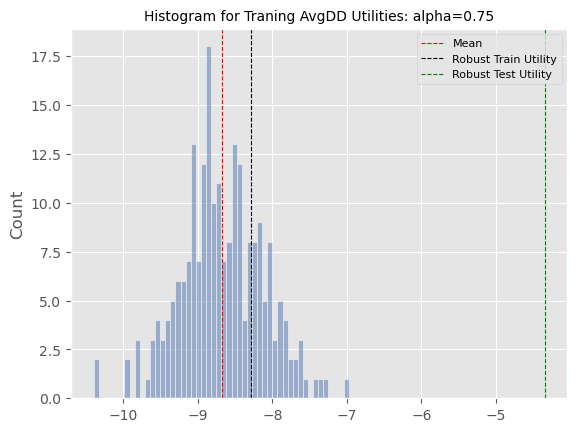

Utility: AvgDD, Functional: means, Alpha: 0.95, Bsize: 100


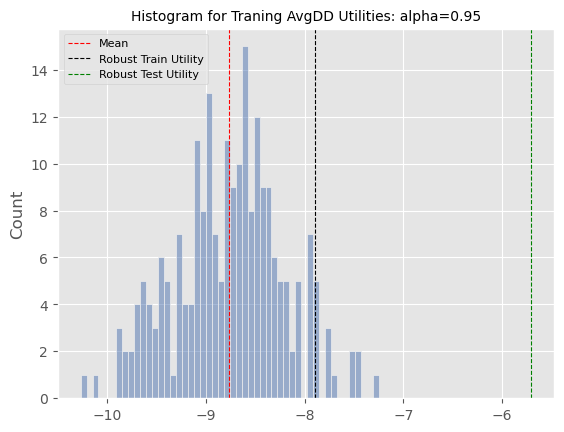

Utility: AvgDD, Functional: means, Alpha: 1.0, Bsize: 100


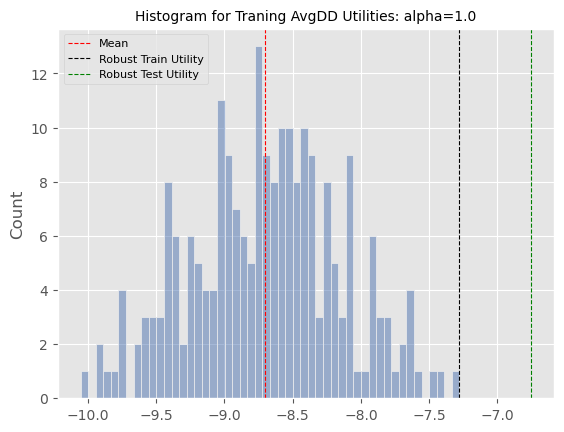

Utility: MaxDD, Functional: means, Alpha: 0.25, Bsize: 100


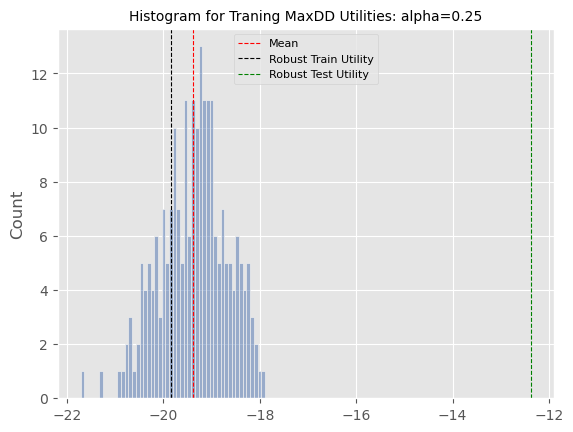

Utility: MaxDD, Functional: means, Alpha: 0.5, Bsize: 100


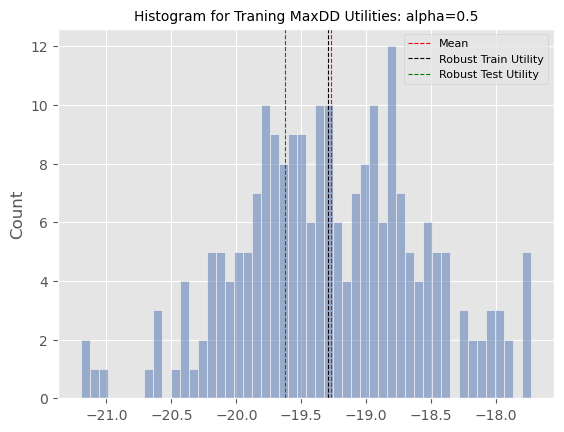

Utility: MaxDD, Functional: means, Alpha: 0.75, Bsize: 100


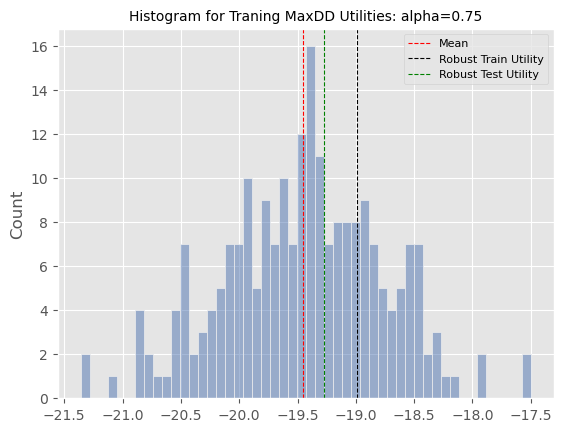

Utility: MaxDD, Functional: means, Alpha: 0.95, Bsize: 100


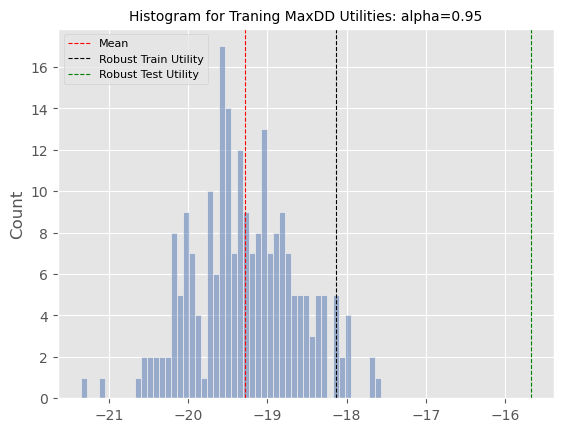

Utility: MaxDD, Functional: means, Alpha: 1.0, Bsize: 100


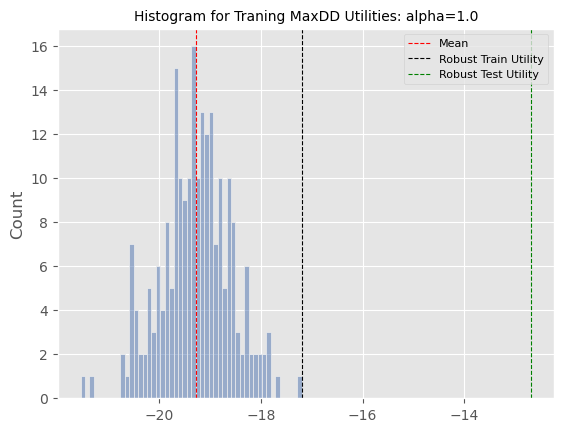

Utility: Sharpe, Functional: means, Alpha: 0.25, Bsize: 100


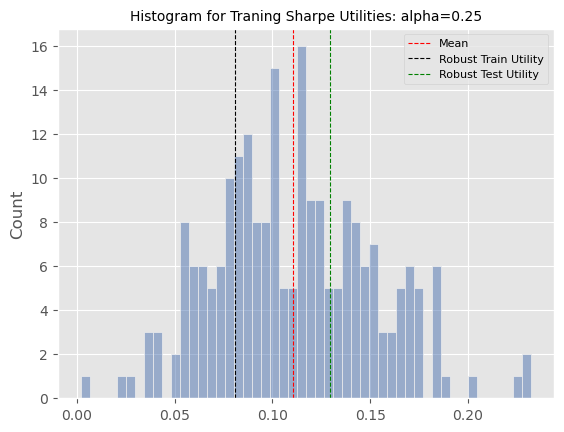

Utility: Sharpe, Functional: means, Alpha: 0.5, Bsize: 100


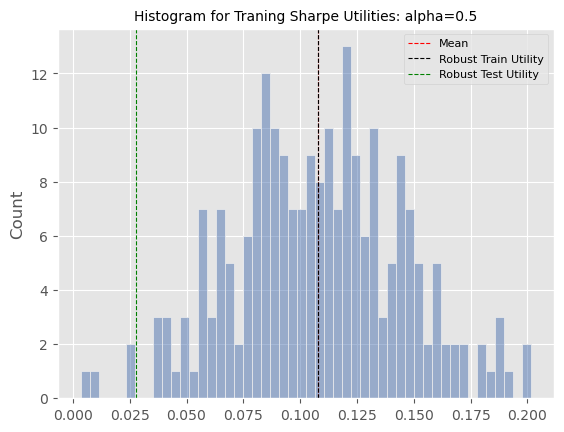

Utility: Sharpe, Functional: means, Alpha: 0.75, Bsize: 100


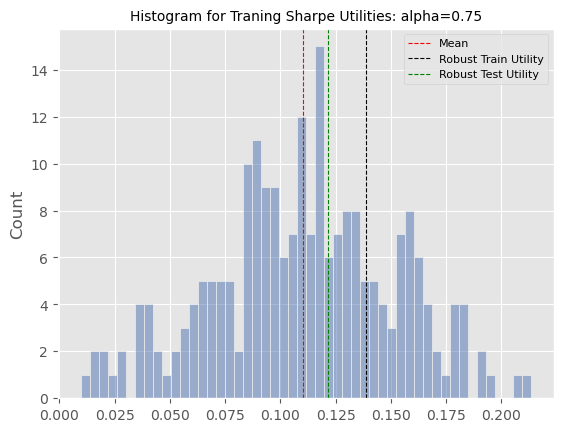

Utility: Sharpe, Functional: means, Alpha: 0.95, Bsize: 100


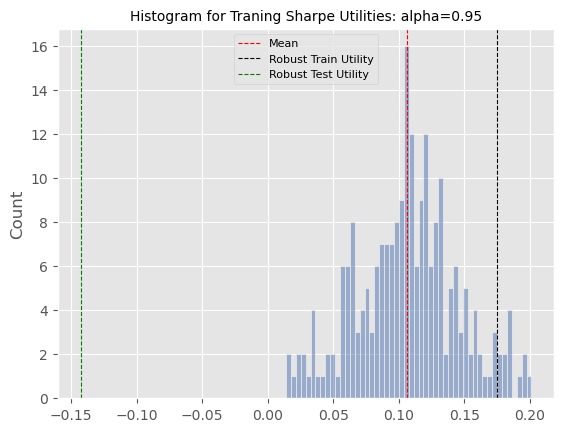

Utility: Sharpe, Functional: means, Alpha: 1.0, Bsize: 100


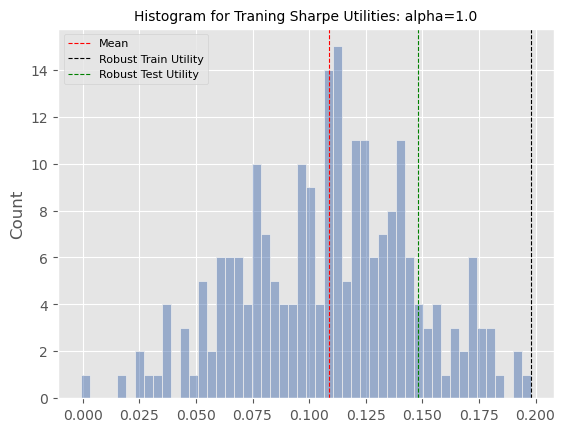

In [5]:
all_results = []
for dir in dirs:
    utility = dir.split("_")[0]
    functional = dir.split("_")[1]
    alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
    Bsize = dir.split("_")[3]

    functionals = Functionals(alpha=float(alpha))

    print(f"Utility: {utility}, Functional: {functional}, Alpha: {alpha}, Bsize: {Bsize}")

    # # list files in directory
    # os.listdir(os.path.join(outputs_path, strategy_name, dir))

    optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
    portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
    portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

    # apply functional to vector of utility vectors
    utilities_val_train = functionals.means(x=optmization_train["utilities"])

    # get the chosen utility vector
    chosen_utility_vector_train = functionals.apply_functional(x=optmization_train["utilities"], func=functional)

    # compute robust utility
    robust_utility_train = chosen_utility_vector_train.mean()

    # portfolio results
    robust_utility_test = diag.compute_metric(portoflio_returns=portfolio_test['agg_scaled_portfolio_returns'], metric_name=utility)

    # save results
    results = {
        "Utility": utility,
        "Functional": functional,
        "Alpha": alpha,
        "Bsize": Bsize,
        "Train Utility Mean": np.round(utilities_val_train.mean().item(), 2),
        "Robust Train Utility": np.round(robust_utility_train.mean().item(), 2),
        "Robust Test Utility": np.round(robust_utility_test, 2),
        "Generalization Gap": np.round(robust_utility_test - robust_utility_train, 2).item(),
    }

    results_df = pd.DataFrame([results])
    all_results.append(results_df)

    # plot
    utility_val_df = pd.DataFrame(utilities_val_train, columns=[utility])
    ax = sns.histplot(data=utility_val_df, palette="deep", bins=50)

    plt.axvline(x=utilities_val_train.mean().item(), color='red', linestyle='--', label='Mean', linewidth=0.8)
    plt.axvline(x=robust_utility_train, color='black', linestyle='--', label='Robust Train Utility', linewidth=0.8)
    plt.axvline(x=robust_utility_test, color='green', linestyle='--', label='Robust Test Utility', linewidth=0.8)
    plt.legend(fontsize=8)
    plt.title(f"Histogram for Traning {dir.split('_')[0]} Utilities: alpha={alpha}", size=10)

    plt.show()
all_results_df = pd.concat(all_results)
all_results_df["Alpha"] = ["max" if val == "1.0" else val for val in all_results_df["Alpha"]]

In [6]:
all_results_df

,Utility,Functional,Alpha,Bsize,Train Utility Mean,Robust Train Utility,Robust Test Utility,Generalization Gap
0,% Positive Ret.,means,0.25,100,0.49,0.49,0.50,0.01
0,% Positive Ret.,means,0.5,100,0.50,0.50,0.52,0.02
0,% Positive Ret.,means,0.75,100,0.49,0.50,0.52,0.02
0,% Positive Ret.,means,0.95,100,0.49,0.50,0.51,0.01
0,% Positive Ret.,means,max,100,0.49,0.50,0.52,0.02
0,AvgDD,means,0.25,100,-8.65,-9.09,-4.97,4.12
0,AvgDD,means,0.5,100,-8.70,-8.72,-6.29,2.42
0,AvgDD,means,0.75,100,-8.68,-8.28,-4.35,3.94
0,AvgDD,means,0.95,100,-8.76,-7.89,-5.70,2.19
0,AvgDD,means,max,100,-8.70,-7.28,-6.75,0.53


In [7]:
all_results_df[["Utility", "Alpha", "Robust Train Utility", "Robust Test Utility", "Generalization Gap"]]

,Utility,Alpha,Robust Train Utility,Robust Test Utility,Generalization Gap
0,% Positive Ret.,0.25,0.49,0.50,0.01
0,% Positive Ret.,0.5,0.50,0.52,0.02
0,% Positive Ret.,0.75,0.50,0.52,0.02
0,% Positive Ret.,0.95,0.50,0.51,0.01
0,% Positive Ret.,max,0.50,0.52,0.02
0,AvgDD,0.25,-9.09,-4.97,4.12
0,AvgDD,0.5,-8.72,-6.29,2.42
0,AvgDD,0.75,-8.28,-4.35,3.94
0,AvgDD,0.95,-7.89,-5.70,2.19
0,AvgDD,max,-7.28,-6.75,0.53
